The number of water molecules is 4000
The timestep is 1 ps
The total simulation time is 10000 ps


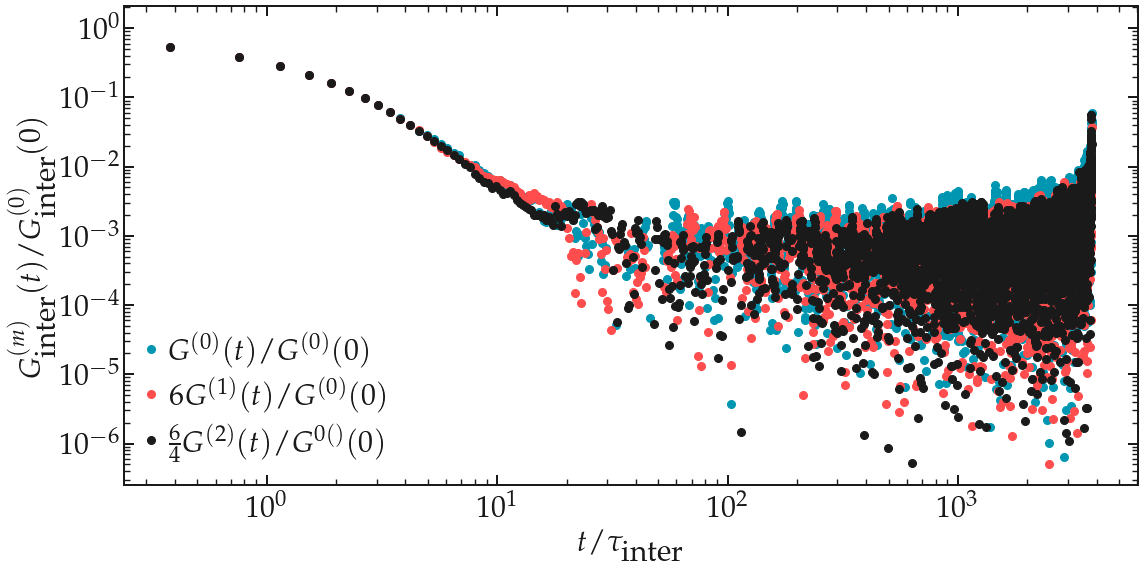

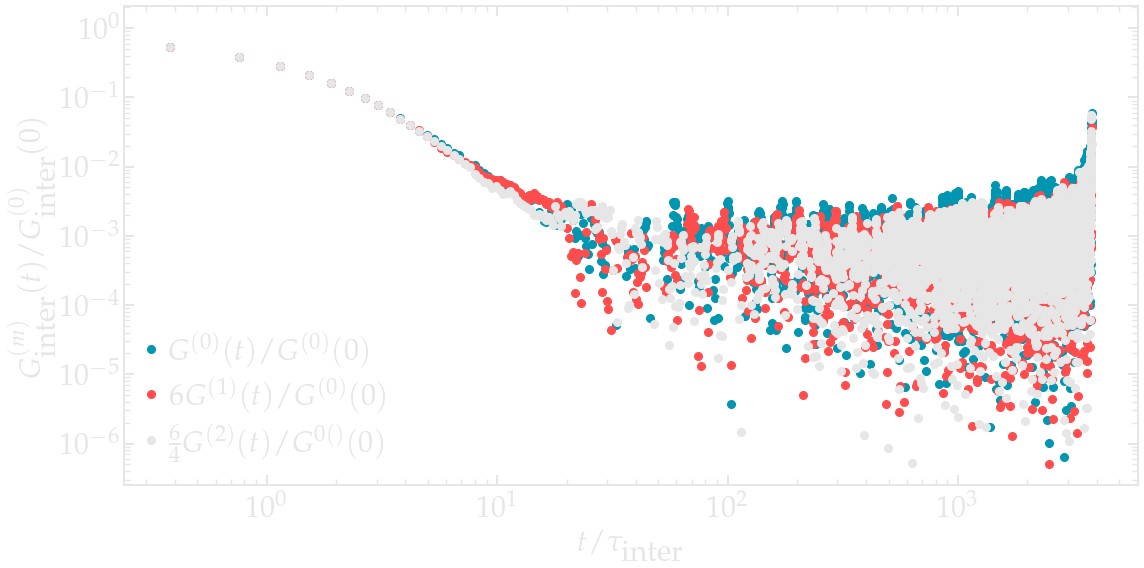

In [11]:
# Import libraries
import numpy as np
import MDAnalysis as mda
import nmrformd as nmrmd

recalculate=False

# For figure plotting
import sys
from matplotlib import pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
fontsize = 30
font = {'family': 'sans', 'color':  'black', 'weight': 'normal', 'size': fontsize}
myblue = [0/ 255, 150/255, 177/ 255]
lightgray = [0.1, 0.1, 0.1]
darkgray = [0.9, 0.9, 0.9]
myred= [255/ 255, 77/255, 77/ 255]
sys.path.append('../../shared/')
from tools import figure_improvement, save_figure

# Path to data
datapath = "../../raw-data/bulk-water/N4000/"

# Create a MDAnalysis universe
u = mda.Universe(datapath+"run.tpr", datapath+"run.xtc")
# u.transfer_to_memory(stop=501) # to analyse only a subpart of the trajectory

# Print a few information
n_molecules = u.atoms.n_residues
print(f"The number of water molecules is {n_molecules}")
timestep = np.int32(u.trajectory.dt)
print(f"The timestep is {timestep} ps")
total_time = np.int32(u.trajectory.totaltime)
print(f"The total simulation time is {total_time} ps")

if recalculate:
    group_i = u.select_atoms("type HW")
    nmr_aniso = nmrmd.NMR(u, group_i, number_i=80, isotropic=False) # 1 hour - 2 hours
    t, gij1, gij2, gij3 = np.vstack([nmr_aniso.t, nmr_aniso.gij])
    # cut-off for frequency and time
    f_1 = 1
    t_1 = 2
    if u.trajectory.n_frames == 10001:
        f_1 = 2600
        t_1 = 9000
    np.savetxt("../../treated-data/best-practice/bulk-water/gij_proportionality.dat", np.vstack([t[:-t_1], gij1[:-t_1], gij2[:-t_1], gij3[:-t_1]]).T)
    # for measuring tau_c - for normalizing the z axis
    sys.path.append("../../../nmrformd/")
    from utilities import calculate_tau
    tau_inter = calculate_tau(nmr_aniso.J, nmr_aniso.gij, nmr_aniso.dim)[0] # ps
    print("Estimate tau",np.round(tau_inter,2),"ps")
else:
    t, gij1, gij2, gij3 = np.loadtxt("../../treated-data/best-practice/bulk-water/gij_proportionality.dat").T
    tau_inter = 2.63

for mode, mygray in zip(['light', 'dark'], [lightgray, darkgray]):
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(111)
    ax1.loglog(nmr_aniso.t/tau_inter, nmr_aniso.gij[0]/nmr_aniso.gij[0][0], 'o', markersize=8, color=myblue, label="$G^{(0)}(t) / G^{(0)}(0)$")
    ax1.loglog(nmr_aniso.t/tau_inter, 6*nmr_aniso.gij[1]/nmr_aniso.gij[0][0], 'o', markersize=8, color=myred, label="$6 G^{(1)}(t) / G^{(0)}(0)$")
    ax1.loglog(nmr_aniso.t/tau_inter, 6*nmr_aniso.gij[2]/nmr_aniso.gij[0][0]/4, 'o', markersize=8, color=mygray, label=r"$\frac{6}{4} G^{(2)}(t) / G^{0()}(0)$")
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$t / \tau_\textrm{inter}$", ylabel=r'$G^{(m)}_\textrm{inter} (t) / G^{(0)}_\textrm{inter} (0)$') #,
                       #xlim=(0.07, 100), ylim=(0.0001, 1))
    save_figure(plt, fig, mode, name='best-practices/proportionality')